## **IMPORTS**

In [67]:
import pandas as pd
import numpy as np
import json

# visualization modules
import seaborn as sns
import matplotlib.pyplot as plt

# pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision.transforms as transforms


## **LOADING THE DATASET**

In [63]:
# Constants
BASE_DIR = 'cassava-leaf-disease-classification/'
IMAGE_DIR = BASE_DIR + 'train_images/'

In [17]:
train_csv = BASE_DIR + 'train.csv'
train_df = pd.read_csv(train_csv)
train_df.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [16]:
# Making the dictionary for disease target labels
with open(BASE_DIR + 'label_num_to_disease_map.json') as file:
    label_map = json.load(file)
    new_label_map = {}
    for key, value in label_map.items():
        new_label_map[int(key)] = value
    label_map = new_label_map

label_map

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [19]:
# Mapping the label names to the train dataframe
train_df["label_name"]= train_df["label"].map(label_map)
train_df.head()

image_id  label                           label_name
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)

## **EXPLORATORY DATA ANALYSIS**

In [38]:
def plot_label_images(class_id, label, num_images=9):
    # get image ids for the specified class
    image_ids = train_df[train_df["label"]==class_id].sample(num_images)["image_id"].to_list()

    # list of the same label repeated num_images times for plotting
    labels = [label for i in range(num_images)]

    # determine grid (subplot) size
    size = int(np.ceil(np.sqrt(num_images)))
    if size*size < num_images:
        size += 1

    # set figure size
    plt.figure(figsize=(15,12))

    # plot images
    for index in range(len(image_ids)):
        image_id = image_ids[index]
        label = labels[index]

        image_path = BASE_DIR + 'train_images/' + image_id
        image = plt.imread(image_path)
        
        plt.subplot(size, size, index + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')

    plt.show()
    
    

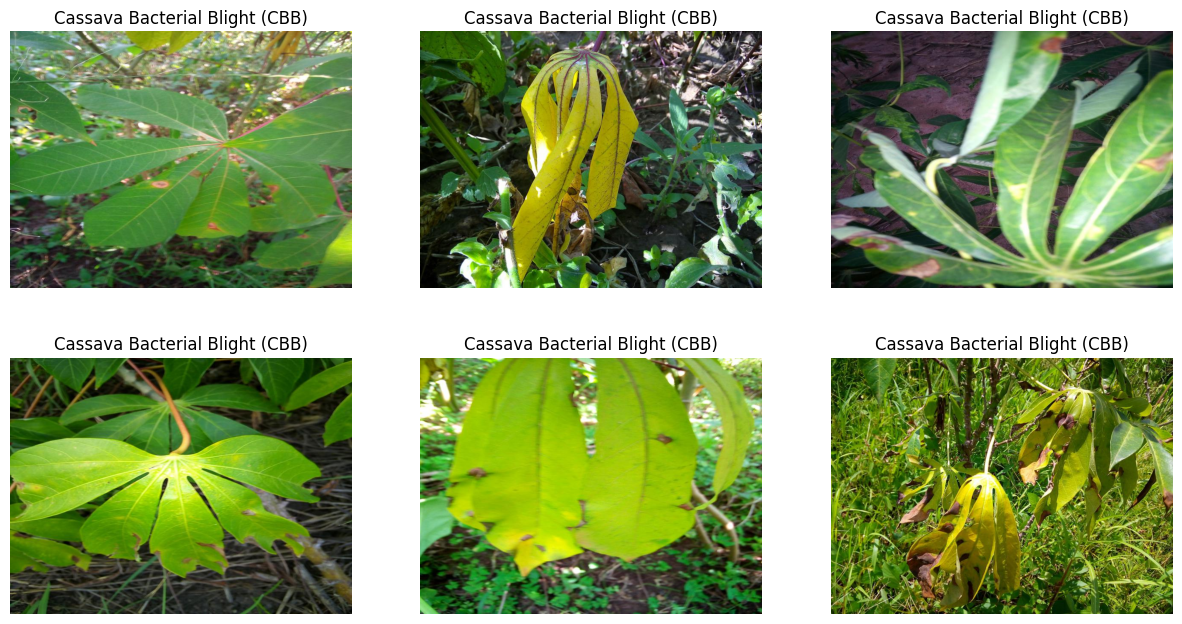

In [45]:
plot_label_images(0, label_map[0], num_images=6)

- all six images display characteristic symptoms of infection by the bacterium Xanthomonas, including brown or yellowing spots on the leaves, necrotics areas with moist edges, and leaves that appear curled or hanging down

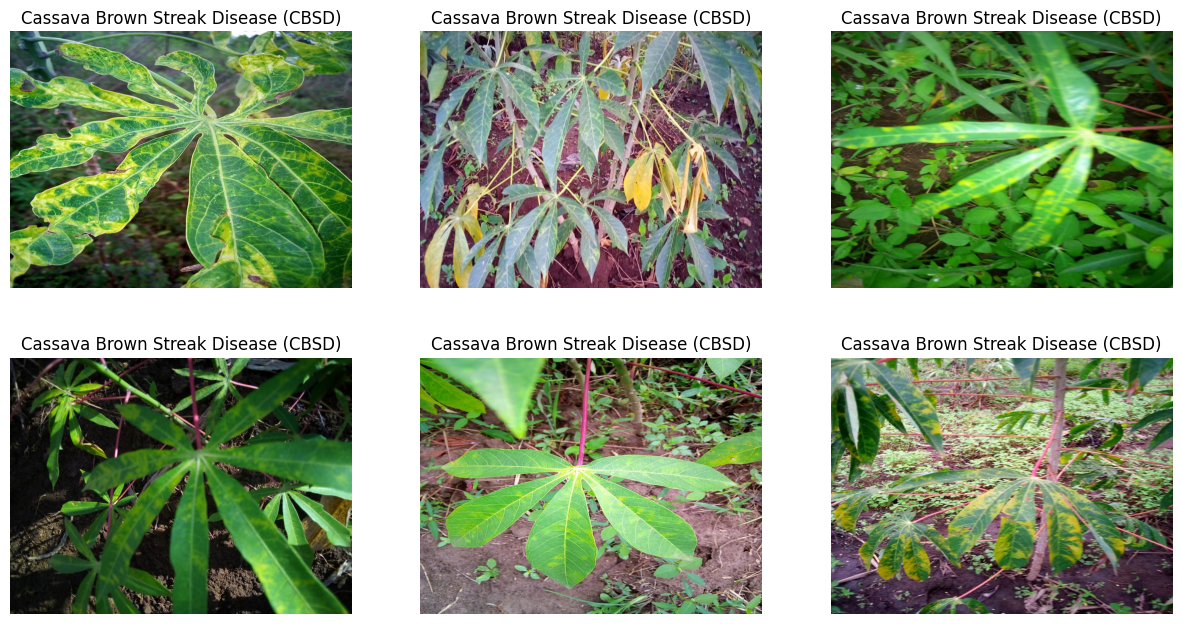

In [46]:
plot_label_images(1, label_map[1], num_images=6)

- the images clearly display viral symptoms including brown spots and chlorosis (yellowing) on the underside of the leaves, uneven brown streaks, and edges that are curled or dry and brittle

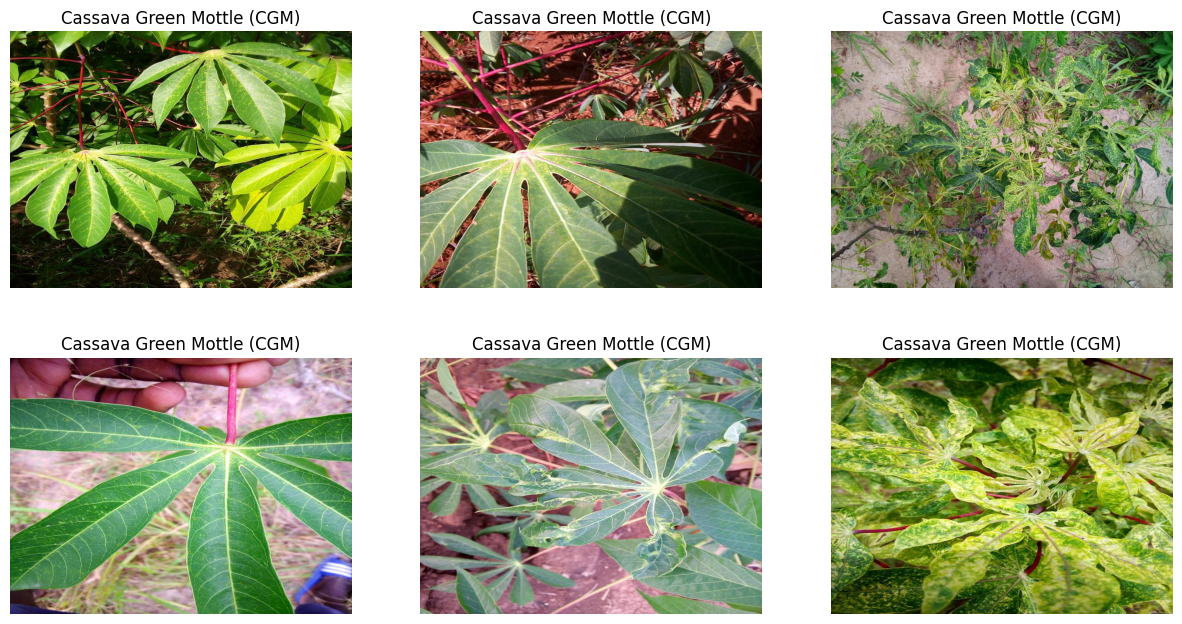

In [47]:
plot_label_images(2, label_map[2], num_images=6)

- the images clearly show the damage caused by the green mite (Mononychellus tanajoa): small yellow speckles on the underside of leaves, leaf edges that are curled and dry, accompanied by mild yellowing of the leaves

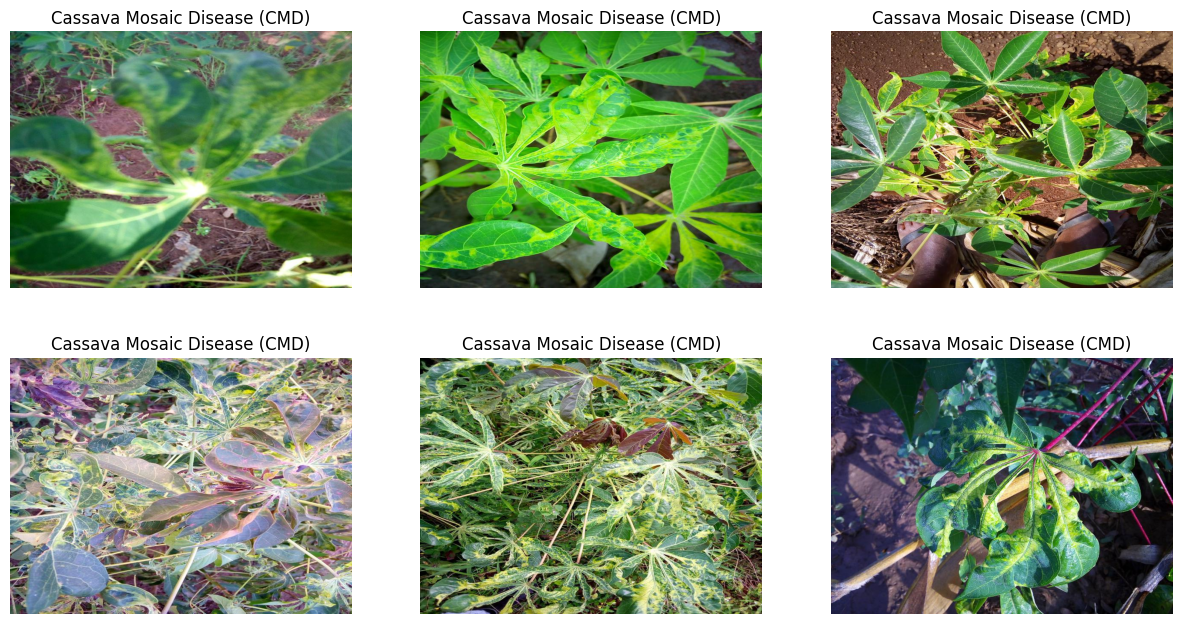

In [48]:
plot_label_images(3, label_map[3], num_images=6)

- the leaves show yellow-green mottled patterns in square or spiral shapes, with minor deformities, curling, and severe yellowing

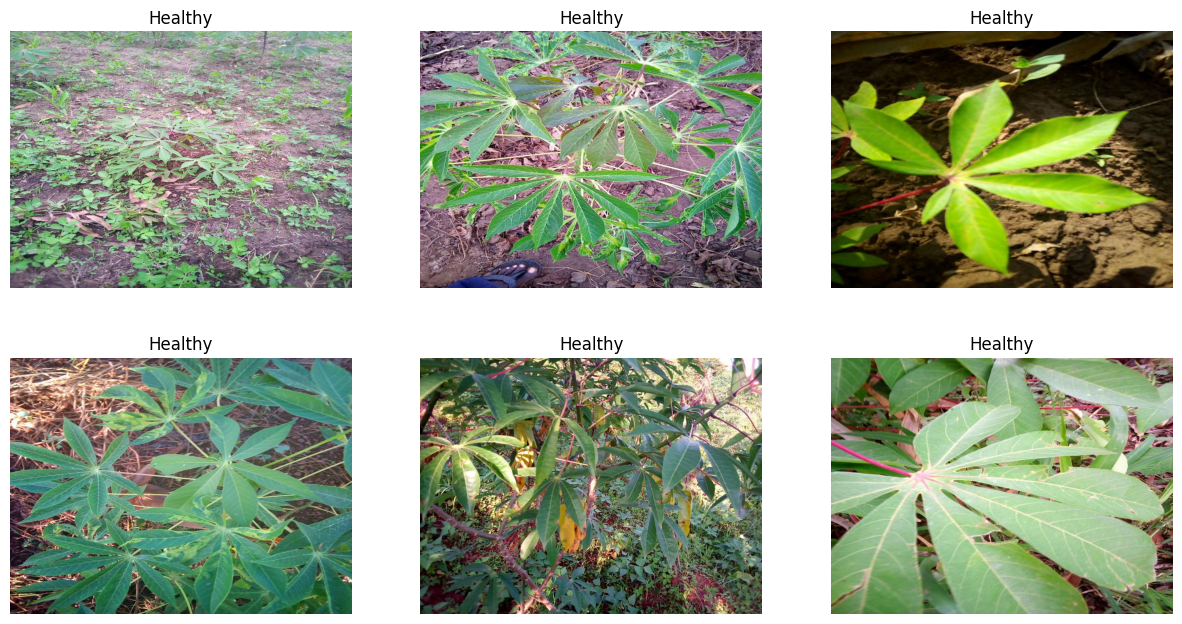

In [50]:
plot_label_images(4, label_map[4], num_images=6)

- healthy cassava leaves appear uniformly green with a smooth, glossy surface. They are large, flat, without curling or spotting, and the leaf veins are clearly defined

In [20]:
def plot_label_distribution(dataframe, label_column):
    plt.figure(figsize=(10,6))
    sns.countplot(data=dataframe, x=label_column, order=dataframe[label_column].value_counts().index)
    plt.title('Distribution of Labels')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

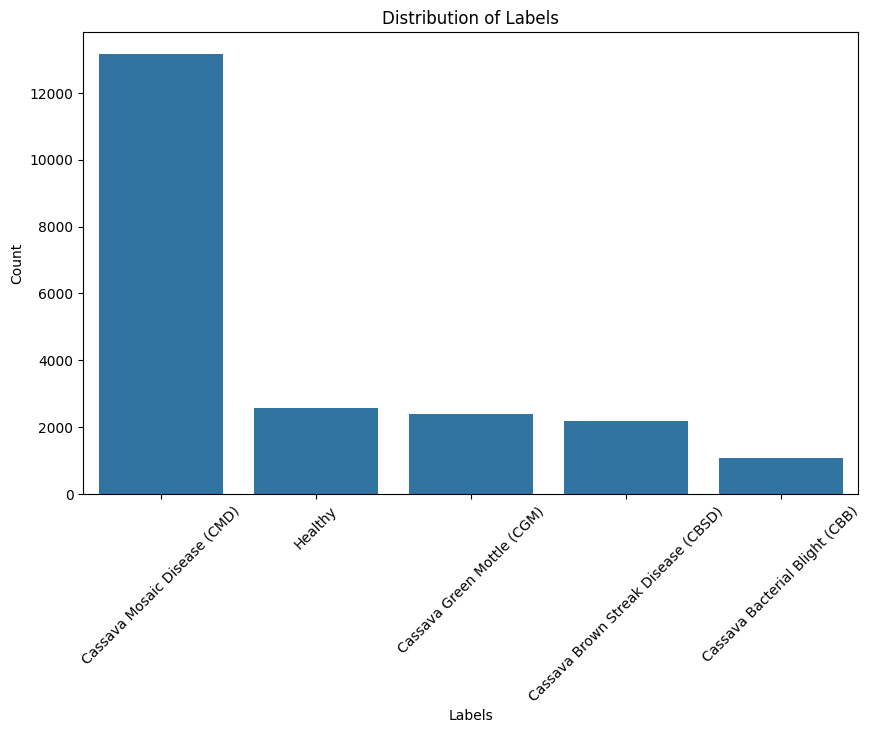

In [21]:
plot_label_distribution(train_df, 'label_name')

In [53]:
def plot_label_distribution_pie(dataframe, label_column):
    # Count occurrences of each label
    label_counts = dataframe[label_column].value_counts()

    # Plot pie chart
    plt.figure(figsize=(5,5))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Label Distribution Pie Chart')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()

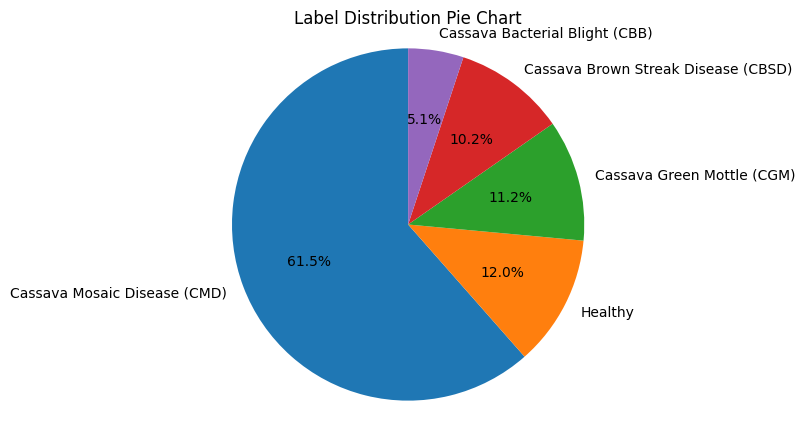

In [54]:
plot_label_distribution_pie(train_df, 'label_name')

### **DATA CLEANING**

##### **Remove duplicates**

In [60]:
# check if there are any duplicate image ids
df_duplicates = train_df[train_df['image_id'].duplicated()]
print(f"Number of duplicate image_ids: {len(df_duplicates)}")

# If duplicates exist, remove them
if len(df_duplicates) > 0:
    train_df = train_df.drop_duplicates(subset=['image_id'], keep='first').reset_index(drop=True)
    print(f"Duplicates removed. New number of rows: {len(train_df)}")

Number of duplicate image_ids: 0


##### **Check for missing values**

In [62]:
print(train_df.isnull().sum())

# there are no missing values in the dataset so no further action is needed

image_id      0
label         0
label_name    0
dtype: int64


##### **Checking if all image files exist**

In [64]:
missing_files = []
for image_id in train_df['image_id']:
    image_path = IMAGE_DIR + image_id
    try:
        with open(image_path, 'rb'):
            pass
    except FileNotFoundError:
        missing_files.append(image_id)

print(f"Number of missing files: {len(missing_files)}")

Number of missing files: 0


### **CONFIGURATION FOR THE PIPELINE**

In [68]:
WIDTH, HEIGHT = 256, 256
IMAGE_SIZE = (WIDTH, HEIGHT)
NUM_CLASSES = len(label_map)
NUM_WORKERS = 24
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
SEED = 42

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ImageNet statistics for normalization
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

Using device: cuda


### **AUGMENTATION PROCESS**